**Author:** [Tayyib Ul Hassan](https://github.com/tayyibgondal)

**Dated:** Oct 30, 2024


## imports

In [2]:
!pip install swig
!pip install "gymnasium[all]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 13.3 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376095 sha256=45c404cb7ff1bb2fd7b4eccd4e08b4e921d1ea3a126e87c692120a52392815bc
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dc

# 1) Cliff walking environment

## 1.1) N-step td algorithm

In [17]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# helper functions
# -------------------------------
def get_action(s, policy):
    row = s // 12
    col = s % 12
    return policy[row][col]

# N-step TD algorithm
def n_step_td(env, policy, n, alpha, discount_factor, num_episodes):
  values = np.zeros(env.observation_space.n)
  rewards = np.zeros(n)
  states = np.zeros(n, dtype=int)

  for episode_no in range(num_episodes):
      s, info = env.reset()
      states[0] = s

      T = float('inf')
      step = 0
      tau = 0  # represents the state which needs to be updated at a particular timestep

      # loop until the value function of 2nd last state is updated
      while tau != T-1:
          # sample next step if episode not terminated
          if step < T:
            action = get_action(s, policy)
            s_next, reward, terminated, truncated, info = env.step(action)
            # save the reward to use it up later
            rewards[step % n] = reward  # save the most recent n rewards in round fashion
            # similarly
            states[(step+1) % n] = s_next

            if terminated:
              T = step + 1
            else:
               s = s_next

          # update the value function of state (from S0 to S_(t-1))
          # get the state to be updated
          tau = step - n + 1
          # when n-1 steps have been taken or n rewards have been collected
          if tau >= 0:
            G = 0
            forward = 0
            for i in range(tau+1, tau+n):
              G += discount_factor**(i-tau-1) * rewards[(step-n+1+forward) % n]
              forward += 1
            if tau + n < T:
              G = G + discount_factor**n * values[states[(tau+n)%n]] # retrieve the value of state present at tau+n

            # Update the state value function
            values[states[tau % n]] += alpha * (G - values[states[tau % n]])

          step = step + 1
  # Reshape the final values into a 4x12 grid
  grid_values = values.reshape(4, 12)

  # Plot the values as a heatmap
  plt.figure(figsize=(10, 5))
  plt.imshow(grid_values, cmap="coolwarm", interpolation="nearest", origin='lower')
  plt.colorbar(label="State Value")
  plt.title("N-step td State Value Function (Cliff walking)")
  plt.xlabel("Cliff walking Grid - Columns")
  plt.ylabel("Rows")
  plt.show()

  return grid_values

### n = 2

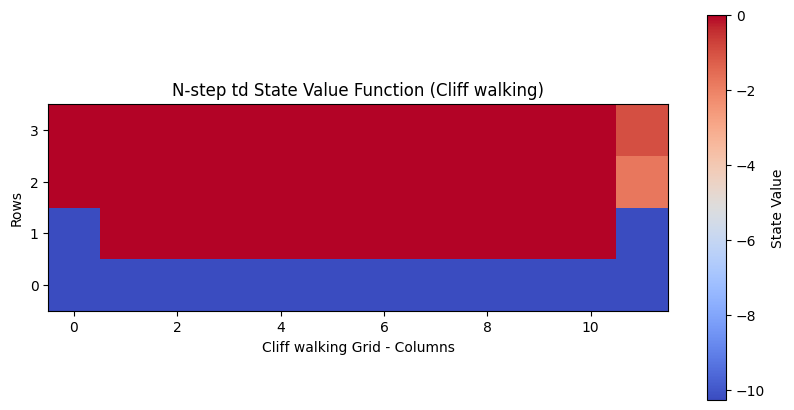

array([[-10.25641026, -10.25641026, -10.25641026, -10.25641026,
        -10.25641026, -10.25641026, -10.25641026, -10.25641026,
        -10.25641026, -10.25641026, -10.25641026, -10.25641026],
       [-10.25641026,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        , -10.25641026],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,  -1.78469283],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,  -1.        ]])

In [18]:
# -------------------------------
# example usage - n step td
# -------------------------------
# inputs to algorithm
env = gym.make('CliffWalking-v0')
# Define the deterministic policy and action names
policy = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
]

n = 2
discount_factor = 0.95
num_episodes = 500000
alpha = 0.05

n_step_td(env, policy, n, alpha, discount_factor, num_episodes)

### n = 3


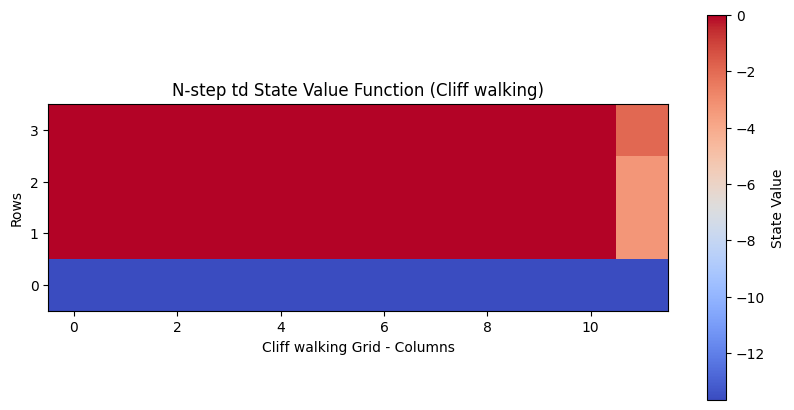

array([[-13.67221735, -13.67221735, -13.67221735, -13.67221735,
        -13.67221735, -13.67221735, -13.67221735, -13.67221735,
        -13.67221735, -13.67221735, -13.67221735, -13.67221735],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,  -3.34876348],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,  -3.34876348],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,  -1.95      ]])

In [20]:
# -------------------------------
# example usage - n step td
# -------------------------------
# inputs to algorithm
env = gym.make('CliffWalking-v0')
# Define the deterministic policy and action names
policy = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
]

n = 3
discount_factor = 0.95
num_episodes = 500000
alpha = 0.05

n_step_td(env, policy, n, alpha, discount_factor, num_episodes)

## 1.2) Backward view td lambda algorithm

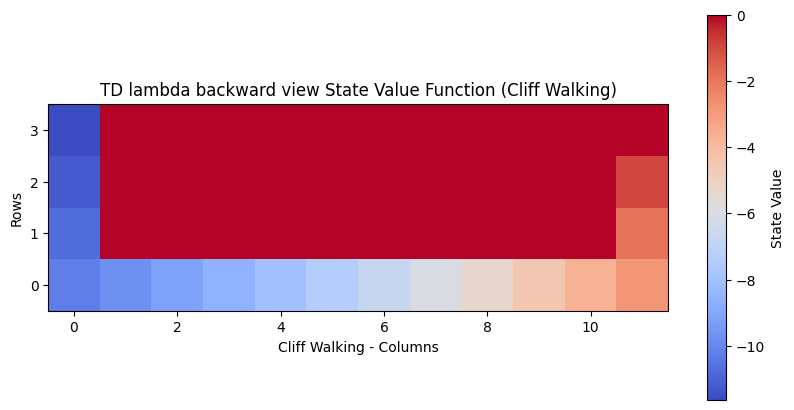

array([[-10.24650042,  -9.73315833,  -9.19279825,  -8.62399815,
         -8.02526122,  -7.39501181,  -6.73159137,  -6.03325408,
         -5.29816219,  -4.52438125,  -3.709875  ,  -2.8525    ],
       [-10.7341754 ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,  -1.95      ],
       [-11.19746663,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,  -1.        ],
       [-11.6375933 ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ]])

In [21]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Helper function to get the action based on the state and policy
def get_action(s, policy):
    row = s // 12
    col = s % 12
    return policy[row][col]

# TD-lambda Backward algorithm
def td_lamda_backward(env, policy, alpha, discount_factor, lamda, num_episodes):
    values = np.zeros(env.observation_space.n)
    e_s = np.zeros(env.observation_space.n)

    for episode_no in range(num_episodes):
        s, info = env.reset()
        e_s.fill(0)  # Reset eligibility traces at the start of each episode
        episode_over = False

        while not episode_over:
            action = get_action(s, policy)
            s_next, reward, terminated, truncated, info = env.step(action)

            # TD error calculation
            td_error = (reward + discount_factor * values[s_next]) - values[s]
            e_s[s] += 1  # Increment eligibility trace for the current state

            # Update all state values and decay eligibility traces
            for i in range(env.observation_space.n):
                values[i] += alpha * td_error * e_s[i]
                e_s[i] *= lamda * discount_factor * e_s[i]

            s = s_next
            episode_over = terminated or truncated

    # Reshape the final values into a 4x12 grid for visualization
    grid_values = values.reshape(4, 12)

    # Plot the values as a heatmap
    plt.figure(figsize=(10, 5))
    plt.imshow(grid_values, cmap="coolwarm", interpolation="nearest", origin='lower')
    plt.colorbar(label="State Value")
    plt.title("TD lambda backward view State Value Function (Cliff Walking)")
    plt.xlabel("Cliff Walking - Columns")
    plt.ylabel("Rows")
    plt.show()

    return grid_values

# -------------------------------
# Example usage of backward TD-lambda
# -------------------------------
env = gym.make('CliffWalking-v0')
policy = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
]

discount_factor = 0.95
num_episodes = 500000
alpha = 0.85
lamda = 0.9  # Added lambda parameter

td_lamda_backward(env, policy, alpha, discount_factor, lamda, num_episodes)

# 2) Frozen lake environment

## 2.1) N-step td algorithm

In [22]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# helper functions
# -------------------------------
def get_action(s, policy):
    row = s // 4
    col = s % 4
    return policy[row][col]

# N-step TD algorithm
def n_step_td(env, policy, n, alpha, discount_factor, num_episodes):
  values = np.zeros(env.observation_space.n)
  rewards = np.zeros(n)
  states = np.zeros(n, dtype=int)

  for episode_no in range(num_episodes):
      s, info = env.reset()
      states[0] = s

      T = float('inf')
      step = 0
      tau = 0  # represents the state which needs to be updated at a particular timestep

      # loop until the value function of 2nd last state is updated
      while tau != T-1:
          # sample next step if episode not terminated
          if step < T:
            action = get_action(s, policy)
            s_next, reward, terminated, truncated, info = env.step(action)
            # save the reward to use it up later
            rewards[step % n] = reward  # save the most recent n rewards in round fashion
            # similarly
            states[(step+1) % n] = s_next

            if terminated:
              T = step + 1
            else:
               s = s_next

          # update the value function of state (from S0 to S_(t-1))
          # get the state to be updated
          tau = step - n + 1
          # when n-1 steps have been taken or n rewards have been collected
          if tau >= 0:
            G = 0
            forward = 0
            for i in range(tau+1, tau+n):
              G += discount_factor**(i-tau-1) * rewards[(step-n+1+forward) % n]
              forward += 1
            if tau + n < T:
              G = G + discount_factor**n * values[states[(tau+n)%n]] # retrieve the value of state present at tau+n

            # Update the state value function
            values[states[tau % n]] += alpha * (G - values[states[tau % n]])

          step = step + 1
  # Reshape the final values into a 4x4 grid
  grid_values = values.reshape(4, 4)

  # Plot the values as a heatmap
  plt.figure(figsize=(10, 5))
  plt.imshow(grid_values, cmap="coolwarm", interpolation="nearest", origin='lower')
  plt.colorbar(label="State Value")
  plt.title("N-step TD State Value Function (FrozenLake)")
  plt.xlabel("FrozenLake Grid - Columns")
  plt.ylabel("Rows")
  plt.show()

  return grid_values

### n = 2

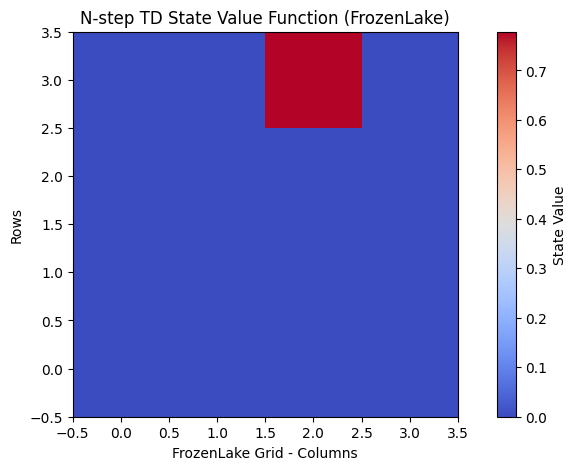

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.77817851, 0.        ]])

In [23]:
# -------------------------------
# example usage - n step td
# -------------------------------
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)

# Define the deterministic policy and action names
policy = [
    [1, 1, 1, 0],
    [1, -1, 1, -1],
    [1, 1, 1, -1],
    [-1, 2, 2, -1]
]

discount_factor = 0.95
num_episodes = 500000
n = 2
alpha = 0.05

n_step_td(env, policy, n, alpha, discount_factor, num_episodes)

### n = 3

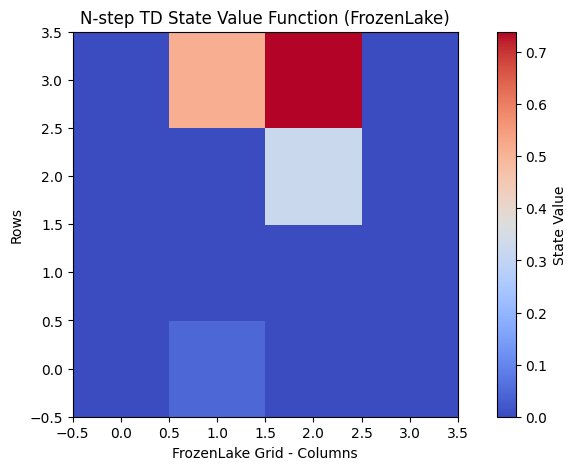

array([[0.        , 0.0475    , 0.        , 0.        ],
       [0.0026745 , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.32126511, 0.        ],
       [0.        , 0.51129332, 0.73905223, 0.        ]])

In [24]:
# -------------------------------
# example usage - n step td
# -------------------------------
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)

# Define the deterministic policy and action names
policy = [
    [1, 1, 1, 0],
    [1, -1, 1, -1],
    [1, 1, 1, -1],
    [-1, 2, 2, -1]
]

discount_factor = 0.95
num_episodes = 500000
n = 3
alpha = 0.05

n_step_td(env, policy, n, alpha, discount_factor, num_episodes)

## 2.2) Backward view td lambda algorithm

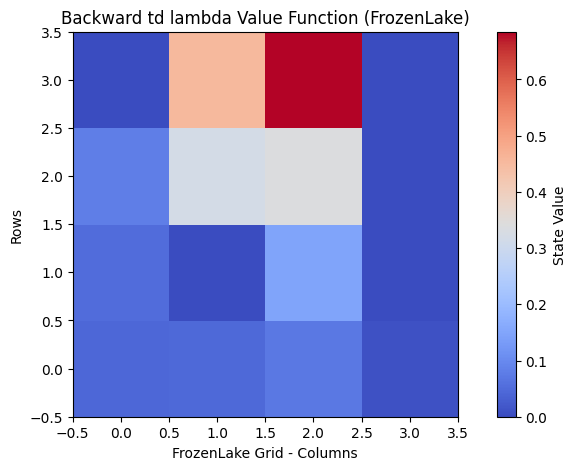

array([[0.04494775, 0.04676888, 0.07111133, 0.01007444],
       [0.05220825, 0.        , 0.14835108, 0.        ],
       [0.0806144 , 0.31917186, 0.33781939, 0.        ],
       [0.        , 0.45287761, 0.68491877, 0.        ]])

In [25]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Helper function to get the action based on the state and policy
def get_action(s, policy):
    row = s // 4
    col = s % 4
    return policy[row][col]

# TD-lambda Backward algorithm
def td_lamda_backward(env, policy, alpha, discount_factor, lamda, num_episodes):
    values = np.zeros(env.observation_space.n)
    e_s = np.zeros(env.observation_space.n)

    for episode_no in range(num_episodes):
        s, info = env.reset()
        e_s.fill(0)  # Reset eligibility traces at the start of each episode
        episode_over = False

        while not episode_over:
            action = get_action(s, policy)
            s_next, reward, terminated, truncated, info = env.step(action)

            # TD error calculation
            td_error = (reward + discount_factor * values[s_next]) - values[s]
            e_s[s] += 1  # Increment eligibility trace for the current state

            # Update all state values and decay eligibility traces
            for i in range(env.observation_space.n):
                values[i] += alpha * td_error * e_s[i]
                e_s[i] *= lamda * discount_factor

            s = s_next
            episode_over = terminated or truncated

    # Reshape the final values into a 4x4 grid for visualization
    grid_values = values.reshape(4, 4)

    # Plot the values as a heatmap
    plt.figure(figsize=(10, 5))
    plt.imshow(grid_values, cmap="coolwarm", interpolation="nearest", origin='lower')
    plt.colorbar(label="State Value")
    plt.title("Backward td lambda Value Function (FrozenLake)")
    plt.xlabel("FrozenLake Grid - Columns")
    plt.ylabel("Rows")
    plt.show()

    return grid_values

# -------------------------------
# Example usage of backward TD-lambda
# -------------------------------
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)

# Define the deterministic policy and action names
policy = [
    [1, 1, 1, 0],
    [1, -1, 1, -1],
    [1, 1, 1, -1],
    [-1, 2, 2, -1]
]

discount_factor = 0.95
num_episodes = 500000
alpha = 0.05
lamda = 0.9  # Added lambda parameter

td_lamda_backward(env, policy, alpha, discount_factor, lamda, num_episodes)
